# AI in pathology image analysis 

<b>Data: </b>You have been provided with 8 H&E files starting with letters A-D. This is grouped as bellow:

   • Group A: A1, A2 (For Model 1 described below)<br>
   • Group B: B1, B2 (For Model 1 described below)<br>
   • Group C: C1, C2 (For Model 2 described below)<br>
   • Group D: D1, D2 (For Model 2 described below)<br>
    
Process the images into patches of 100 by 100. 
Then, generate the train and test set using 90:10 ratio. 
Build 2 CNN models and assess their performance. 

### Image pre-processing

In [47]:
import os.path
import cv2 as cv
from PIL import Image
import numpy as np
import pandas as pd
import random as rand

In [155]:
# determining how much tissue I have in a tile / do not want to images with white spaces

def tissue_percent(n):
    """
    Determine the percentage of non zero pixel in an image.
    The function returns the percentage of zero pixels (idea of tissue content)
    Parameters:
            n: image numpy array RGB
    
    """
    # Checking if there are 3 chnannels
    
    if (len(n.shape) == 3) and (n.shape[2] == 3):
        # Adding all the pixel values from the three channels
        n_s = n[:, :, 0] + n[:, :, 1] + n[:, :, 2]
        # Calculating the percentage of nonzero (100 - (nonzeros/size * 100))
        mask_p = 100 - (np.count_nonzero(n_s) / (n_s.size * 100))
        
    # if images in grey scale
    
    else:
        # if image have odd shape, hence the above will not work
        # To solve the problem - creating an edge case switch
        mask_p = 100 - np.count_nonzero(n) / n.size * 100
    return 100 - mask_p


# Getting suitably sized image tiles
# CNN models require specific image sizes.

def fixed_tiles(img, d=200, th=20, name="base"):
    """
    Function to get 2 * 2 fixed image tiles.
    Parameters:
            img: Image to cut up
            d: Dimension of the tiles
            th: The percentage white space to exclude
            name: The prefix for the tile id
                
    """
    
    # Seting a hold for the tiles
    tiles = dict()
    
    # Seting a counter / which tile
    n = 0
    
    # Looping over the image x and y aixs according to the required size d
    for x in range(0, img.shape[0] - d, d): # X aixs
        for y in range(0, img.shape[1] - d, d): # Y aixs
            
            # Createing a window using the x and y cordinates
            window = img[x:x + d, y:y + d, :]
            
            # Geting the percentage of white spaces using the predefined function
            cont = tissue_percent(window)
            
            # Checking that the tile has required tissue content set by th
            if cont <= th:
                # print("Tile {} is good".format(n))
                tiles[name + str(n)] = window
                n += 1
            else:
                pass
            # print("Tile {} is bad".format(n))
    return tiles



# Saving image to file
def save_image(img, path):
    
    """
    Saving images to file
    Parameters:
            img: Image to save
            path: The location to save the file
            
    """
    
    if img is not None:
        if img.dtype == "bool":
            img = img.astype("uint8") * 255
        elif img.dtype == "float64":
            img = (img * 255).astype("uint8")
        # checking if I am not overwriting existing image
        img = Image.fromarray(img)
        img.save(path)
    return


# Saving the tiles to file
def save_tiles(tile, path):

    """
    Function to save tiles in a dictionary to file.
    Parameters:
            cube: Dictionary of the tiles
            path: The location to save the file
            
    """
    
    # Checking that path exists
    if not os.path.exists(path):
        os.makedirs(path)
        
    # Looping of the items in the dictionary
    for z in tile:
            # Saving to file using the function "save_image"
            save_image(tile[z], os.path.join(path, z + ".jpg")) # save in jpg format
    print("Done")
    return

In [156]:
# loading images and checking the shapes to see if the images loaded

image_list = ("A1.jpg", "A2.jpg", "B1.jpg", "B2.jpg","C1.jpg", "C2.jpg", "D1.jpg", "D2.jpg")

all_tiles = list()
path = list()
group = list()

for i in image_list:
    img = cv.imread(i)
    
    # processing the tiles
    tiles = fixed_tiles(img, d=200, th=20, name=i[0:2])
    print ("Image {}".format(i[0:2]),"shape is {}".format(img.shape))
    
    # obtaining name, path and group
    for tile in tiles:
        
        all_tiles.append(tile)
        path.append(os.path.join(os.getcwd(), "tiles", tile + ".jpg"))
        group.append(tile[0])
        
    # Checking the length to see if the process worked
    print("tile length is {}".format(len(tiles)))
    
    # Saving image tiles for further processing
    save_tiles(tiles, "tiles")
    
# Modeling data into one data frame - tile name, path and assigned group - model training

data = pd.DataFrame(list(zip(all_tiles, path, group)),
                    columns =["name", "path", "group"])

data.to_csv("traindata.csv", index=False)

Image A1 shape is (898, 1292, 3)
tile length is 24
Done
Image A2 shape is (898, 1310, 3)
tile length is 24
Done
Image B1 shape is (918, 1276, 3)
tile length is 24
Done
Image B2 shape is (898, 1316, 3)
tile length is 24
Done
Image C1 shape is (882, 1274, 3)
tile length is 24
Done
Image C2 shape is (960, 1234, 3)
tile length is 24
Done
Image D1 shape is (886, 1230, 3)
tile length is 24
Done
Image D2 shape is (688, 1164, 3)
tile length is 15
Done


In [157]:
# Splitting "traindata" into two parts one for each model

model_1_data = data[(data["group"] == "A") | (data["group"] == "B")]
model_2_data = data[(data["group"] == "C") | (data["group"] == "D")]

model_1_data

,name,path,group
0,A10,/Users/mapanavici/Library/CloudStorage/OneDriv...,A
1,A11,/Users/mapanavici/Library/CloudStorage/OneDriv...,A
2,A12,/Users/mapanavici/Library/CloudStorage/OneDriv...,A
3,A13,/Users/mapanavici/Library/CloudStorage/OneDriv...,A
4,A14,/Users/mapanavici/Library/CloudStorage/OneDriv...,A
...,...,...,...
91,B219,/Users/mapanavici/Library/CloudStorage/OneDriv...,B
92,B220,/Users/mapanavici/Library/CloudStorage/OneDriv...,B
93,B221,/Users/mapanavici/Library/CloudStorage/OneDriv...,B
94,B222,/Users/mapanavici/Library/CloudStorage/OneDriv...,B


In [158]:
model_2_data

,name,path,group
96,C10,/Users/mapanavici/Library/CloudStorage/OneDriv...,C
97,C11,/Users/mapanavici/Library/CloudStorage/OneDriv...,C
98,C12,/Users/mapanavici/Library/CloudStorage/OneDriv...,C
99,C13,/Users/mapanavici/Library/CloudStorage/OneDriv...,C
100,C14,/Users/mapanavici/Library/CloudStorage/OneDriv...,C
...,...,...,...
178,D210,/Users/mapanavici/Library/CloudStorage/OneDriv...,D
179,D211,/Users/mapanavici/Library/CloudStorage/OneDriv...,D
180,D212,/Users/mapanavici/Library/CloudStorage/OneDriv...,D
181,D213,/Users/mapanavici/Library/CloudStorage/OneDriv...,D


In [222]:
from sklearn.model_selection import train_test_split

# Preparing the train test split for model 1 and model 2 data

# Splitting on the 90/10

train_1, test_1 = train_test_split(model_1_data, test_size=10)
train_2, test_2 = train_test_split(model_2_data, test_size=10)

# Checking the group counts in each split
print(train_1["group"].value_counts())
print(test_1["group"].value_counts())

print(train_2["group"].value_counts())
print(test_2["group"].value_counts())

group
A    45
B    41
Name: count, dtype: int64
group
B    7
A    3
Name: count, dtype: int64
group
C    44
D    33
Name: count, dtype: int64
group
D    6
C    4
Name: count, dtype: int64


### Building 2 CNN models

Finally, create two CNN models to predict 1) A vs B and 2) C vs D. i.e.,

    • Model 1: Use the A and B images to build the model.
    • Model 2: Use the C and D images to build the model.


Found 86 validated image filenames belonging to 2 classes.
Found 10 validated image filenames belonging to 2 classes.
Found 77 validated image filenames belonging to 2 classes.
Found 10 validated image filenames belonging to 2 classes.


/var/folders/56/88kjvy650k91bm96ynm0c6fm0000gs/T/ipykernel_88713/3241137597.py:76: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 3, i + 1)
/var/folders/56/88kjvy650k91bm96ynm0c6fm0000gs/T/ipykernel_88713/3241137597.py:76: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 3, i + 1)


'Done'

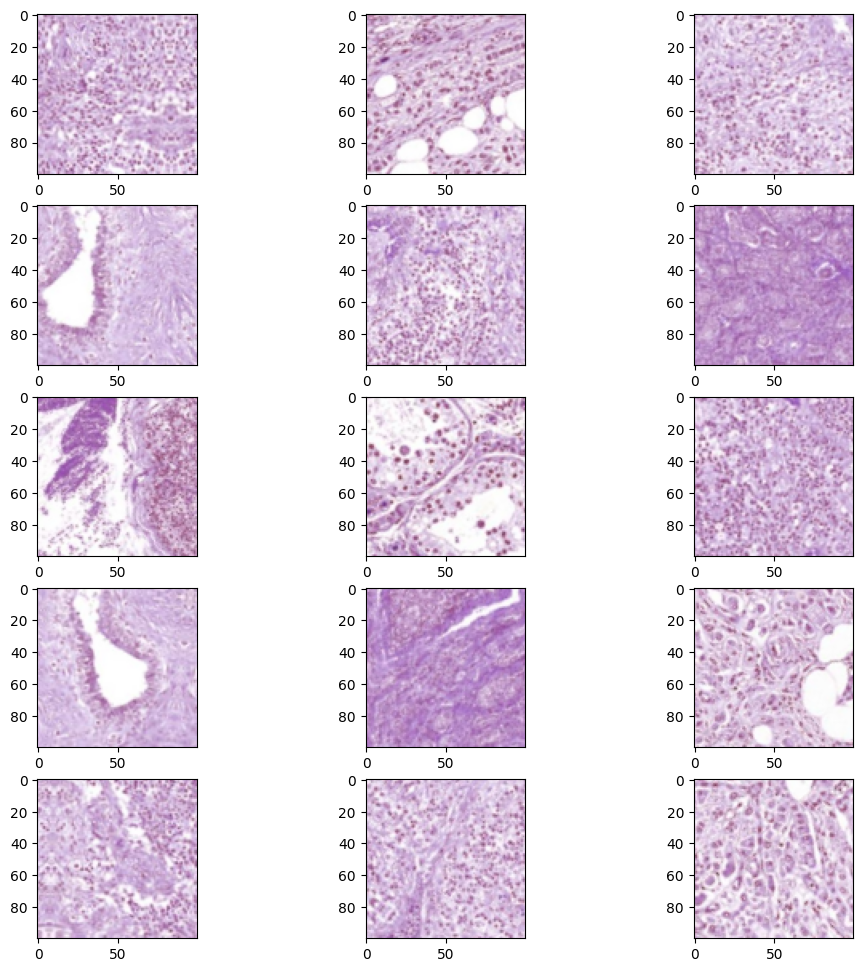

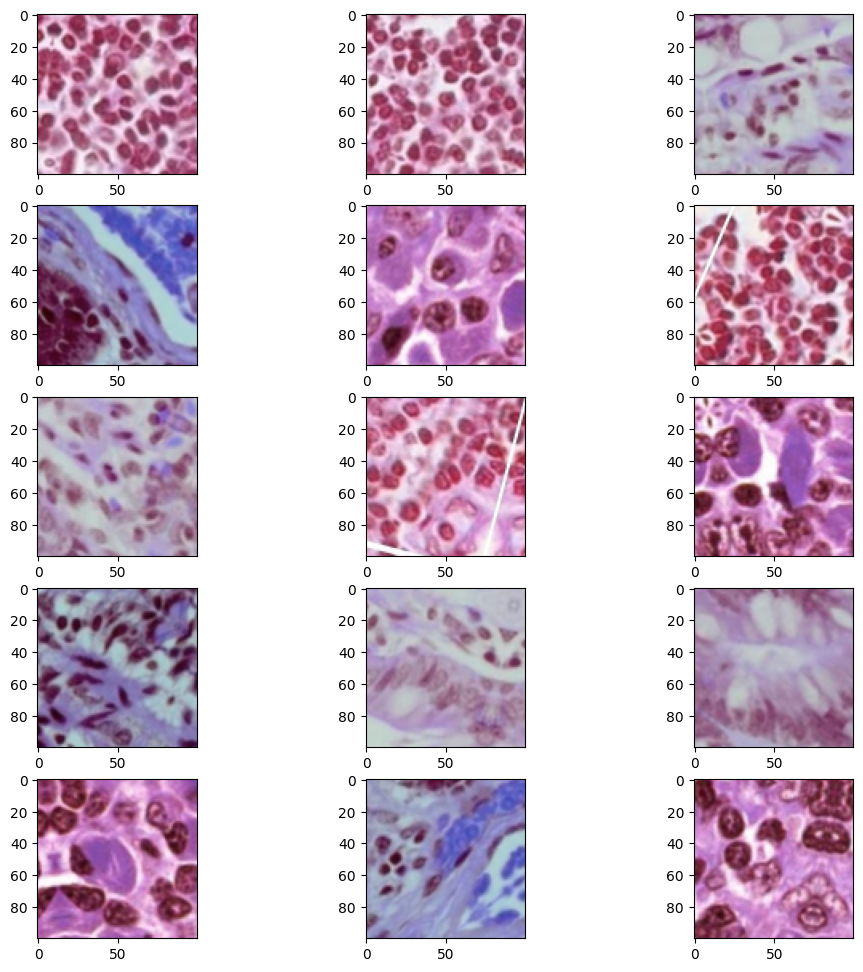

In [223]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Preparing the data generator

# Preparing the train generator with augumentation
gtrain = ImageDataGenerator(rescale=1.0/255.0, # scale pixele
                            vertical_flip=True, # randomly flipping 
                            horizontal_flip=True,
                            height_shift_range = 0.2,
                            fill_mode="reflect", rotation_range=90,
                            data_format="channels_last")

# Preparing the test generator without augumentation / no variation in the test
gtest = ImageDataGenerator(rescale=1.0/255.0,
                            data_format="channels_last")


# Using the generator to flow the data from the each dataframe

# Training set 1
d_gtrain_1 = gtrain.flow_from_dataframe(dataframe=train_1, 
                                        shuffle=True, # shuffle imag
                                        x_col="path", y_col="group", 
                                        target_size=(100, 100),
                                        class_mode="categorical", 
                                        save_format="JPEG", 
                                        batch_size=10, 
                                        validate_filenames=True) 

# Test set 1
d_gtest_1 = gtest.flow_from_dataframe(dataframe=test_1, 
                                     x_col="path",
                                     validate_filenames=True, 
                                     y_col="group",
                                     target_size=(100, 100), 
                                     class_mode="categorical",
                                     save_format="JPEG", 
                                     batch_size=10)

# Training set 2
d_gtrain_2 = gtrain.flow_from_dataframe(dataframe=train_2, 
                                        shuffle=True,
                                        x_col="path", 
                                        y_col="group", 
                                        target_size=(100, 100),
                                        class_mode="categorical", 
                                        save_format="JPEG",
                                        batch_size=10, 
                                        validate_filenames=True)

# Test set 2
d_gtest_2 = gtest.flow_from_dataframe(dataframe=test_2, 
                                      x_col="path",
                                      validate_filenames=True, 
                                      y_col="group",
                                      target_size=(100, 100), 
                                      class_mode="categorical",
                                      save_format="JPEG", 
                                      batch_size=10)


# Checking the data to make sure it has what I need

def vis_gen(x, batch=0, name="generator.pdf"):
    
    """
    Function to check image generator
    :param x: The image generator object.
    :param batch: Which batch from the generator to plot.
    :param name: Name of pdf to save with.
    
    """
    plt.subplots(figsize=(12, 12))
    for i in range(0, 15):
        plt.subplot(5, 3, i + 1)
        for X_batch, Y_batch in x:
            image = X_batch[batch]
            plt.imshow(image)
            break
    plt.savefig(name)
    return "Done"

# Checking the training data to make sure things went into the generator
vis_gen(d_gtrain_1, batch=0, name="train_images.pdf")
vis_gen(d_gtrain_2, batch=0, name="train_images.pdf")

### Defining models

<b>Model 1: </b>Using the A and B images to build the model.

In [224]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2


def define_model_1():

    model = Sequential()

    model.add(Conv2D(16, (3, 3),
              activation='relu',
              kernel_initializer='he_uniform',
              input_shape=(100, 100, 3)))
    
    model.add(MaxPooling2D((2, 2)))
    
    model.add(BatchNormalization())

    model.add(Flatten())

    model.add(Dropout(0.3))

    model.add(Dense(30, activation='relu',  kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'))

    # The prediction layer
    model.add(Dense(2, activation='softmax'))
    
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [225]:
from tensorflow.keras.callbacks import EarlyStopping

# Callback - stopping model when the perfomance stars to decline.

early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               verbose=1,
                               patience=3)

In [226]:
# Initiating the model 1
model_1 = define_model_1()

model_1.summary()

history = model_1.fit(d_gtrain_1, epochs=10,
                    validation_steps=d_gtest_1.samples//10,
                    validation_data=d_gtest_1,
                    verbose=1,
                    callbacks=early_stopping)

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 49, 49, 16)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_35 (Ba  (None, 49, 49, 16)        64        
 tchNormalization)                                               
                                                                 
 flatten_34 (Flatten)        (None, 38416)             0         
                                                                 
 dropout_34 (Dropout)        (None, 38416)             0         
                                                                 
 dense_68 (Dense)            (None, 30)              

In [227]:
# Evaluating the model 1

score_1 = model_1.evaluate(d_gtest_1, verbose=0)

print("Test loss:", score_1[0])
print("Test accuracy:", score_1[1])

Test loss: 4.272698879241943
Test accuracy: 0.699999988079071


<b>Model 2: </b>Using the C and D images to build the model.

In [228]:
def define_model_2():
    
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), 
                     activation='relu',
                     kernel_initializer='he_uniform',
                     input_shape=(100, 100, 3)))

    model.add(MaxPooling2D((2, 2)))

    model.add(BatchNormalization())

    model.add(Flatten())

    model.add(Dropout(0.3))

    model.add(Dense(30, activation='relu', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'))

    # The prediction layer
    model.add(Dense(2, activation='softmax'))

    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [229]:
# tends to overfit very quickly, so dropping patience to just 1
early_stopping_2 = EarlyStopping(monitor='val_loss', 
                                 mode='min', 
                                 verbose=1,
                                 patience=1)

In [230]:
# Initiating the model 1
model_2 = define_model_2()

model_2.summary()

history = model_2.fit(d_gtrain_2, epochs=10,
                     validation_steps=d_gtest_2.samples//10,
                     validation_data=d_gtest_2,
                     verbose=1,
                     callbacks=early_stopping_2)

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 49, 49, 16)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_36 (Ba  (None, 49, 49, 16)        64        
 tchNormalization)                                               
                                                                 
 flatten_35 (Flatten)        (None, 38416)             0         
                                                                 
 dropout_35 (Dropout)        (None, 38416)             0         
                                                                 
 dense_70 (Dense)            (None, 30)              

In [231]:
# Evaluating the model 2

score_2 = model_2.evaluate(d_gtest_2, verbose=0)

print("Test loss:", score_2[0])
print("Test accuracy:", score_2[1])

Test loss: 148.71694946289062
Test accuracy: 0.6000000238418579


### What is the training and validation accuracy for model 1?

    • Model 1 - training accuracy: 0.8837, validation accuracy: 0.6999
    
### What is the training and validation accuracy for model 2?

    • Model 2 - training accuracy: accuracy: 0.8182, validation accuracy: 0.6000
    
### Which of the models performed best on its dataset and suggest possible reasons for the differences in performance.

From the first glance it would seem that model 1 is performing better over model 2, but actually what
both models are doing, they always predict the majority class (Model 1 test set: B - 7, A - 3; model 2 test
data: D - 6, C-4). Multiple attemps were made where I generated different ratios of the classes in test set
to test this assumption - as the ratios change, the test accuracy would change accordinlgy, supporting
this assumption. This together with good performance on a training set indicates that the model overfits training data and simply predicts the majority
class. I have performned many different experiments with multiple different model architectures where I
significantly dropped the model complexity as well as in some instances I introduced multiple dropout
layers to reduce the bias, or introduced generalization (kernel_regularizer and bias_regularizer) to help
model generalise better. Even after many different solutions, models would still overfit the training data.
These models simply do not work as the data is extremely sparse and both models don't have enough
data to learn the features well and generalise. More data are needed to make models more robust and
accurate. The other options could be to implement transfer learning.
